<a name='0'></a>

# MobileNetV2: Inverted Residuals and Linear Bottlenecks

MobileNets are efficient networks that are suited for mobile and embedded vision applications. [MobileNetV2](https://arxiv.org/abs/1801.04381) is an improved version of MobileNetV1 and it is based on the inverted residual blocks with depthwise convolutions as intermediate layer in the inverted residual blocks.

MobileNetV2 is designed for resource constrained environments such as mobile and embedded devices. It has a good accuracy-latency tradeoff, it demonstrated excellent results in image classification, object detection and image segmentation.

What's in here:

* [Introduction](#1)
* [Depthwise Separable Convolutions](#2)
* [Linear Bottlenecks and Inverted Residual Blocks](#3)
* [MobileNetV2 Architecture](#4)
* [MobileNetV2 implementation](#5)
* [Final Notes](#6)
* [Reference Implementations](#7)

<a name='1'></a>

## 1. Introduction

Deep convolutional neural networks have revolutionalized computer vision. While deep and modern ConvNets networks work better, they require computational resources which makes it hard to be deployed in mobile and edge devices self-driving cars, robots, mobile phones, etc...These devices typically posses low computational resources and they thus require networks that have low latency.

Due to its low latency, MobileNetV2 is one of the most efficient network architectures for mobile-based visual applications.

MobileNetV2 uses inverted residual blocks and linear bottlenecks. The inverted blocks uses depthwise separable convolutions as the intermediate layer. Let's learn more about depthwise separable convolutions, inverted residual blocks, and linear bottlenecks and we will review and implement the whole architecture of MobileNetv2.

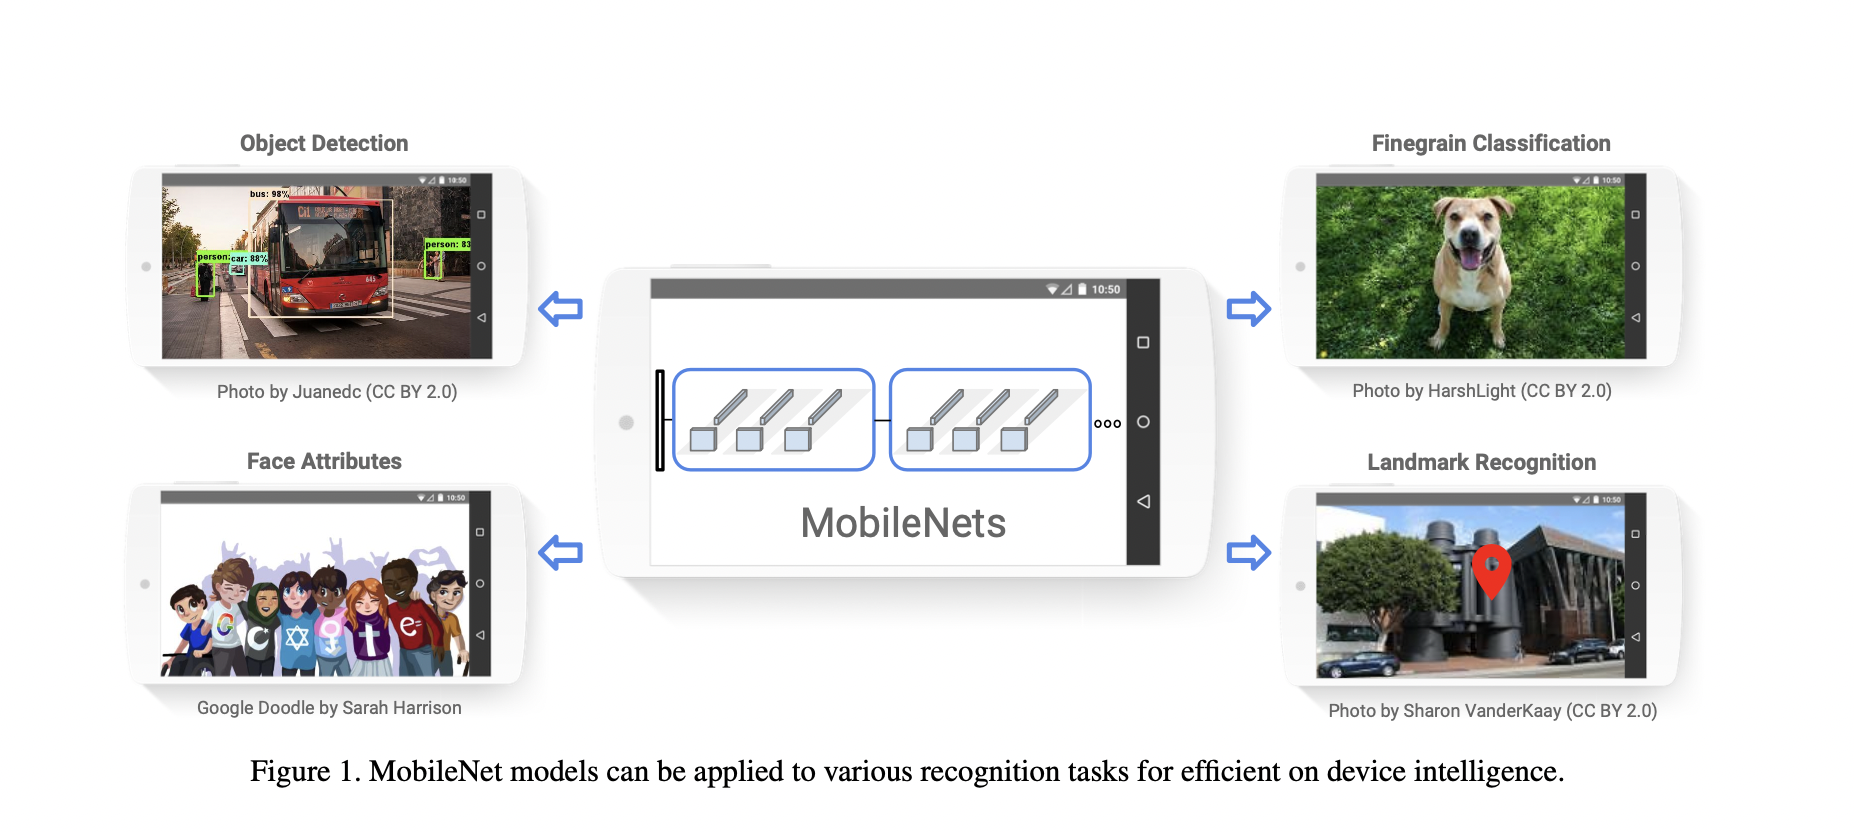

<a name='2'></a>
## 2. Depthwise Separable Convolutions

A depthwise separable convolution is a special kind of grouped convolutions that performs spatial convolutions on each independent channel, concatenate the results and apply 1x1 convolution(pointwise) to the results.

A depthwise separable convolution is essentially made of depthwise(channel-wise) convolution and 1x1 convolution(point wise convolution). Depthwise or channel wise convolution applies a single filter to each input channel. Depthwise convolution is also similar to standard convolution whose groups are equal to the number of channels/filters. The pointwise or 1x1 convolution is used to combine the outputs of depthwise convolution layer. In essence, 1x1 convolution is equivalent to a fully connected layer(linear layer).

Depthwise separable convolution is simply the combination of depthwise or channel wise convolution and 1x1 convolution.

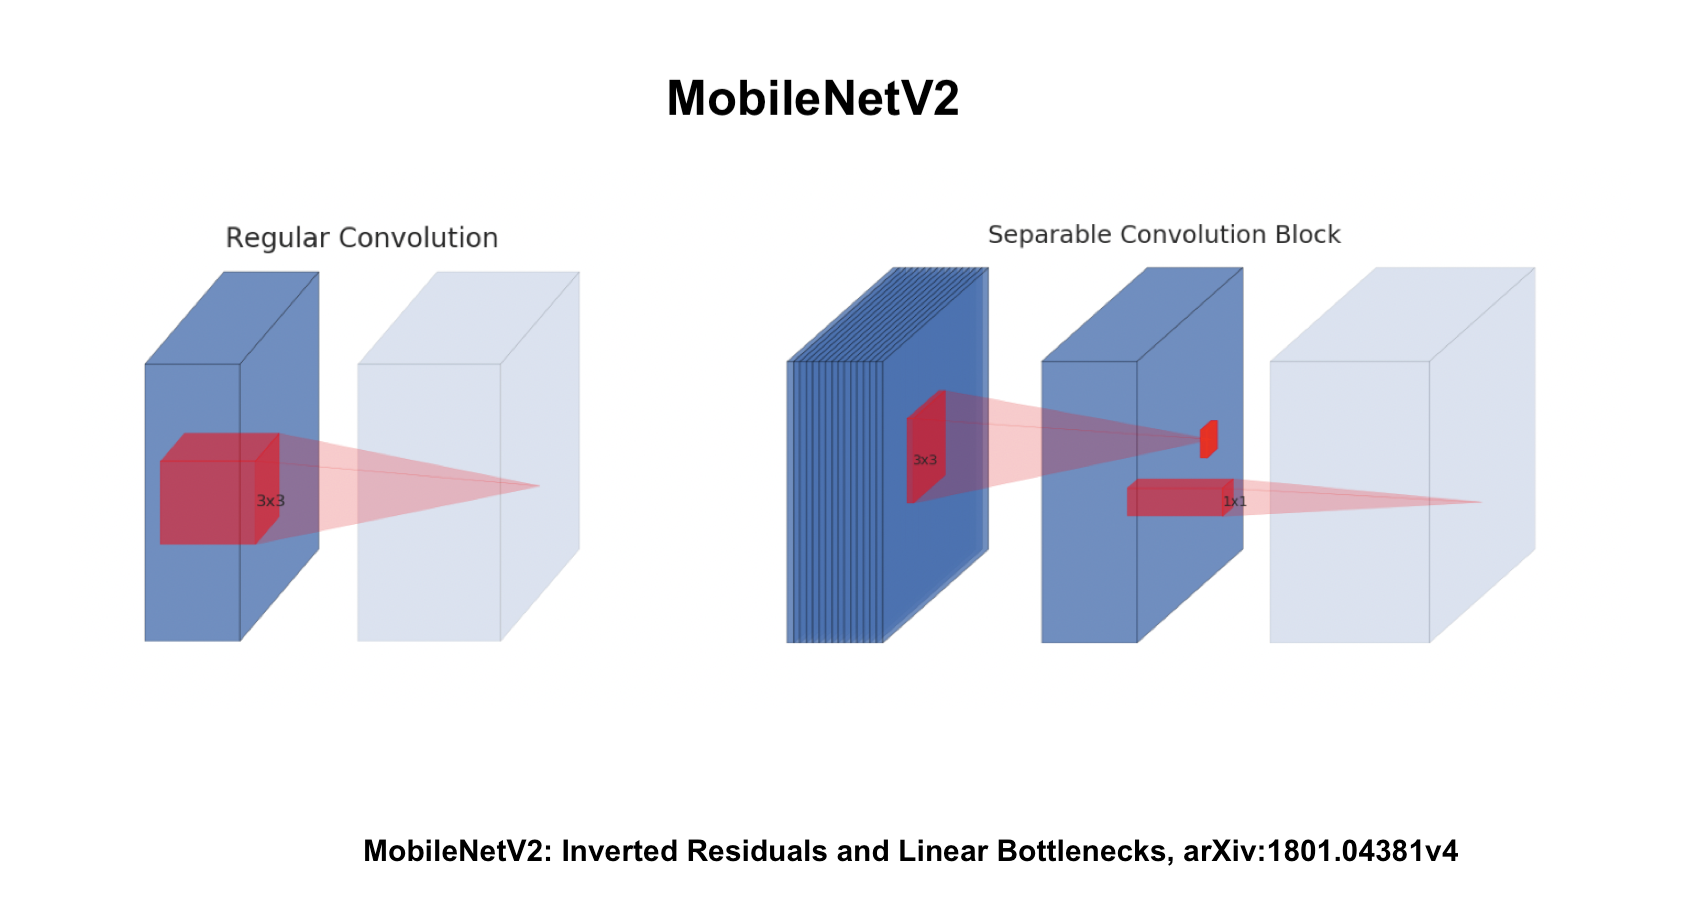

MobileNets use 3x3 depthwise seperable convolutions and as the authors reported, it is less computationally expensive than standard convolutions, up to between 8 & 9 times.

<a name='3'></a>

## 3. Inverted Residual and Linear Bottlenects

### Linear Blocks

To prevent the losses of information, the authors opted to use linear layers into the convolutional blocks. They removed non-linearities(ReLU) into the input of the residual blocks. Below image depicts that, the diagonal hashed layers don't have non-linearities.

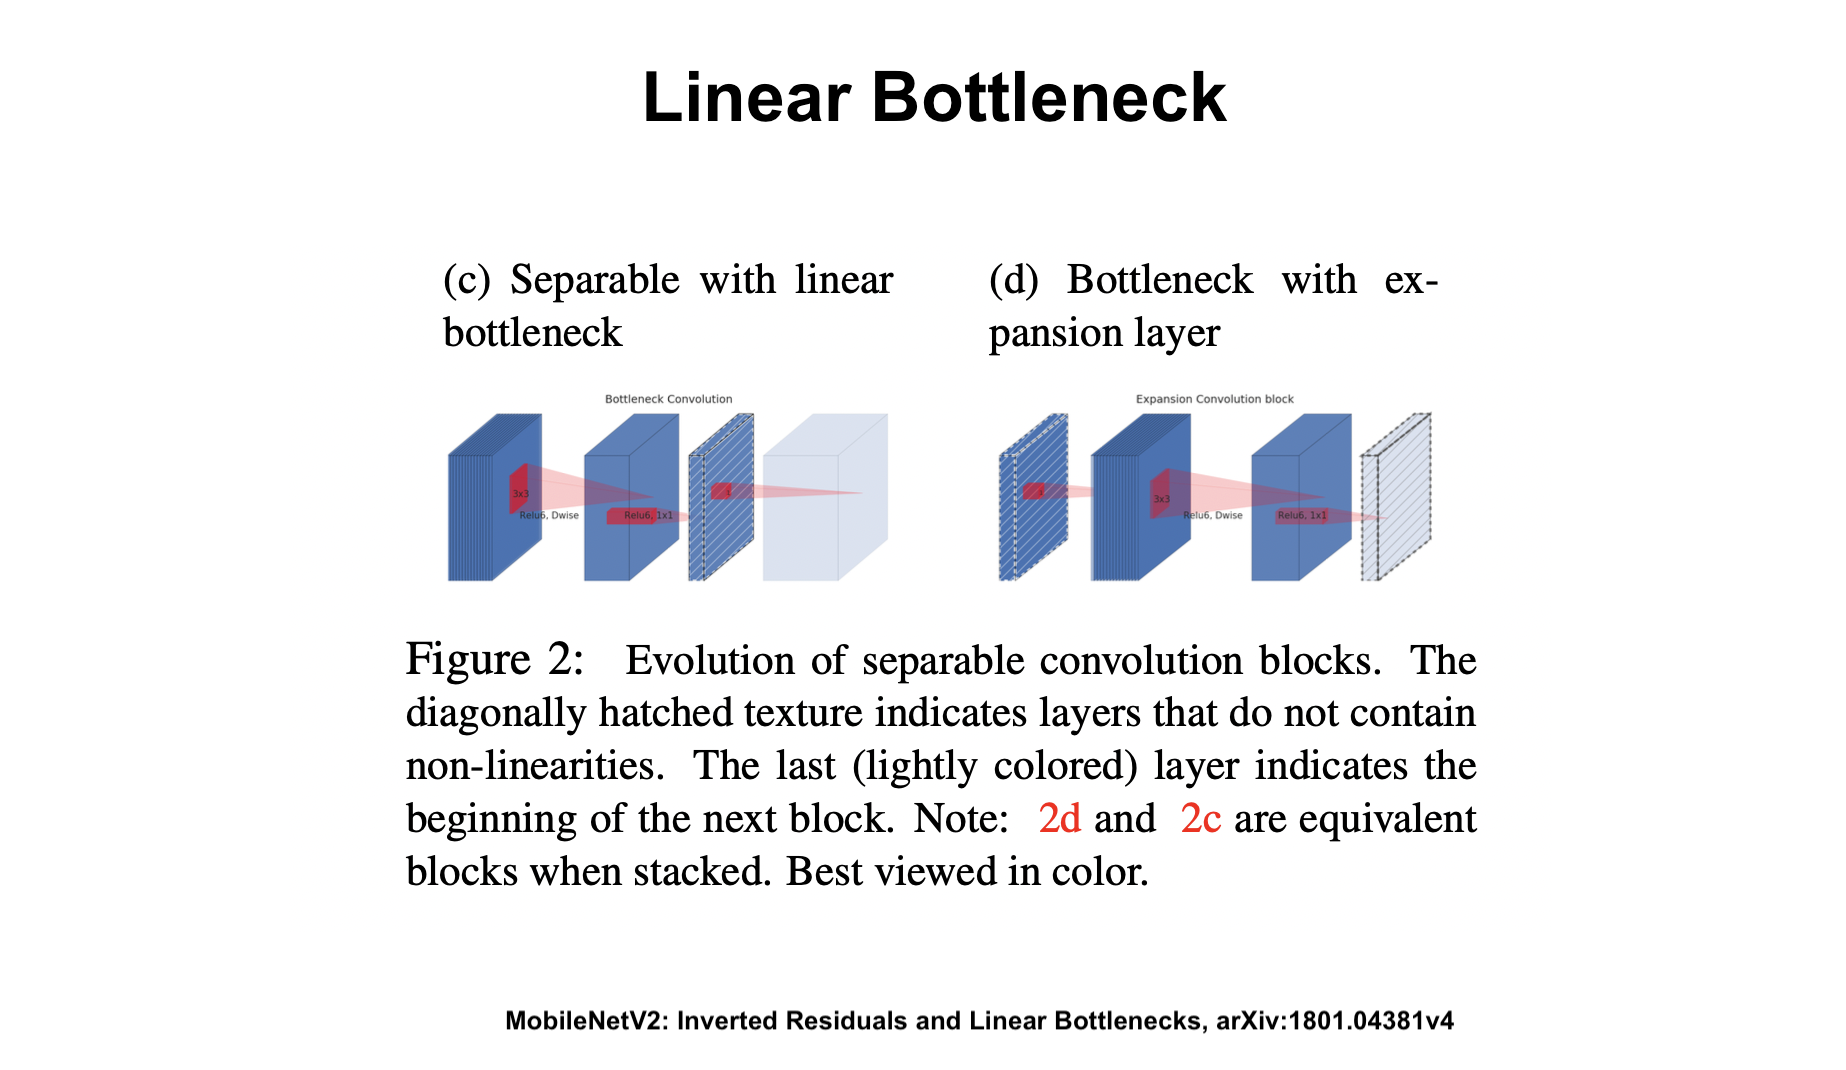

### Inverted Residual Block

The following image depicts the standard and inverted residual block. The shortcut is used directly between the bottlenecks(1x1 convolutions that have fewer output channels than their respective input channels). The shortcuts improves the ability of gradients to propogate across multiple layers. The notable thing about inverted residual block is that it's memory efficient as it reduces the dimensionality of the representations.

From the image, the diagonal hashed layers do not contain RELU non-linearities.

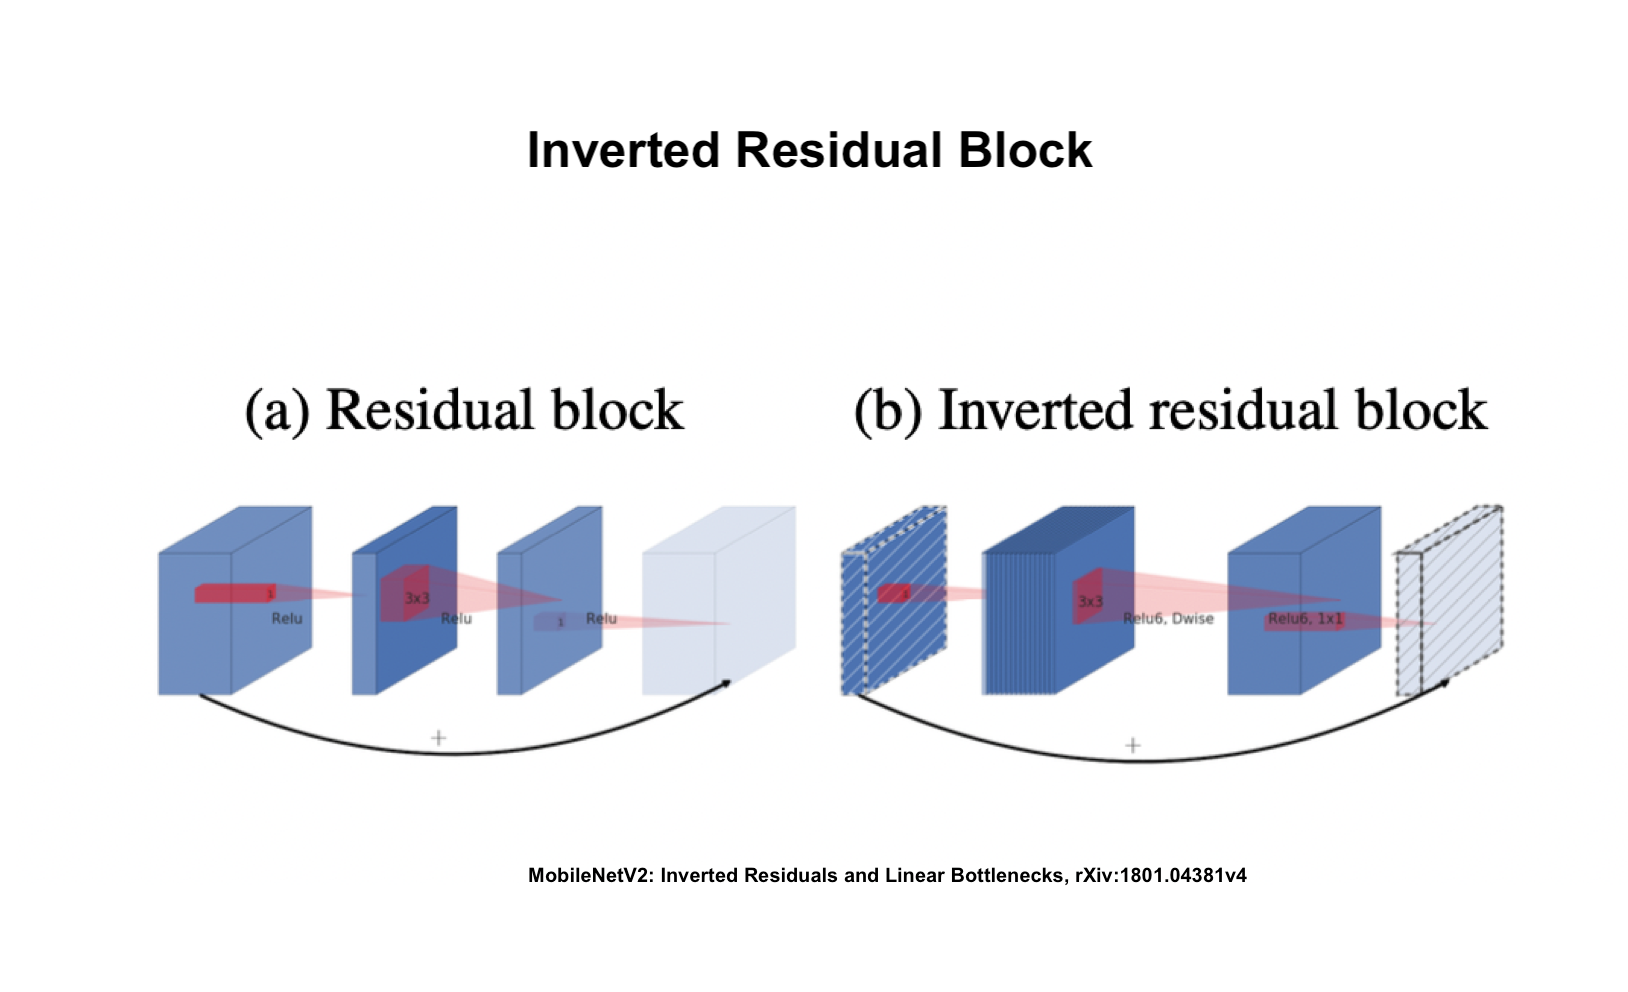

<a name='4'></a>

## 4. MobileNet Architecture

The basic building block of MobileNetV2 is inverted residual block whose bottlenecks are depthwise separable convolutions.

The network starts with a stem of a 3x3 convolutional layer with 32 filters and stride 2. The stem is followed by 19 residual bottleneck blocks. The depthwise separable convolutions in inverted residual blocks are of 3x3 kernel size. ReLU is used as the nonlinearity due to its robustness. Also, during the training, the network uses batch normalization and dropout.

Further more, like MobileNetV1, the authors used resolution and width multiplier as tunable hyperparameters to reduce the dimensionality of the network even more. In our implementation, we will assume that they are both 1(that means operating on full resolution and whole network). Below image shows the impacts of resolution multiplier. Note how even small input image resolutions achieves good results as higher resolution!


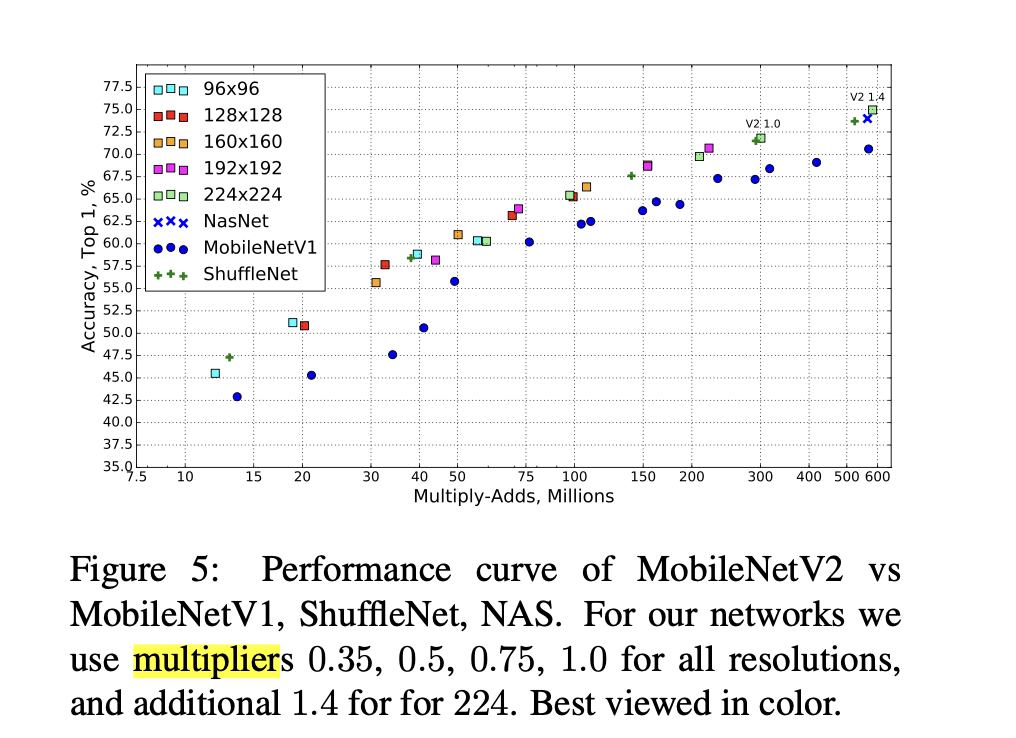

Below image depicts the architecture of MobileNet.

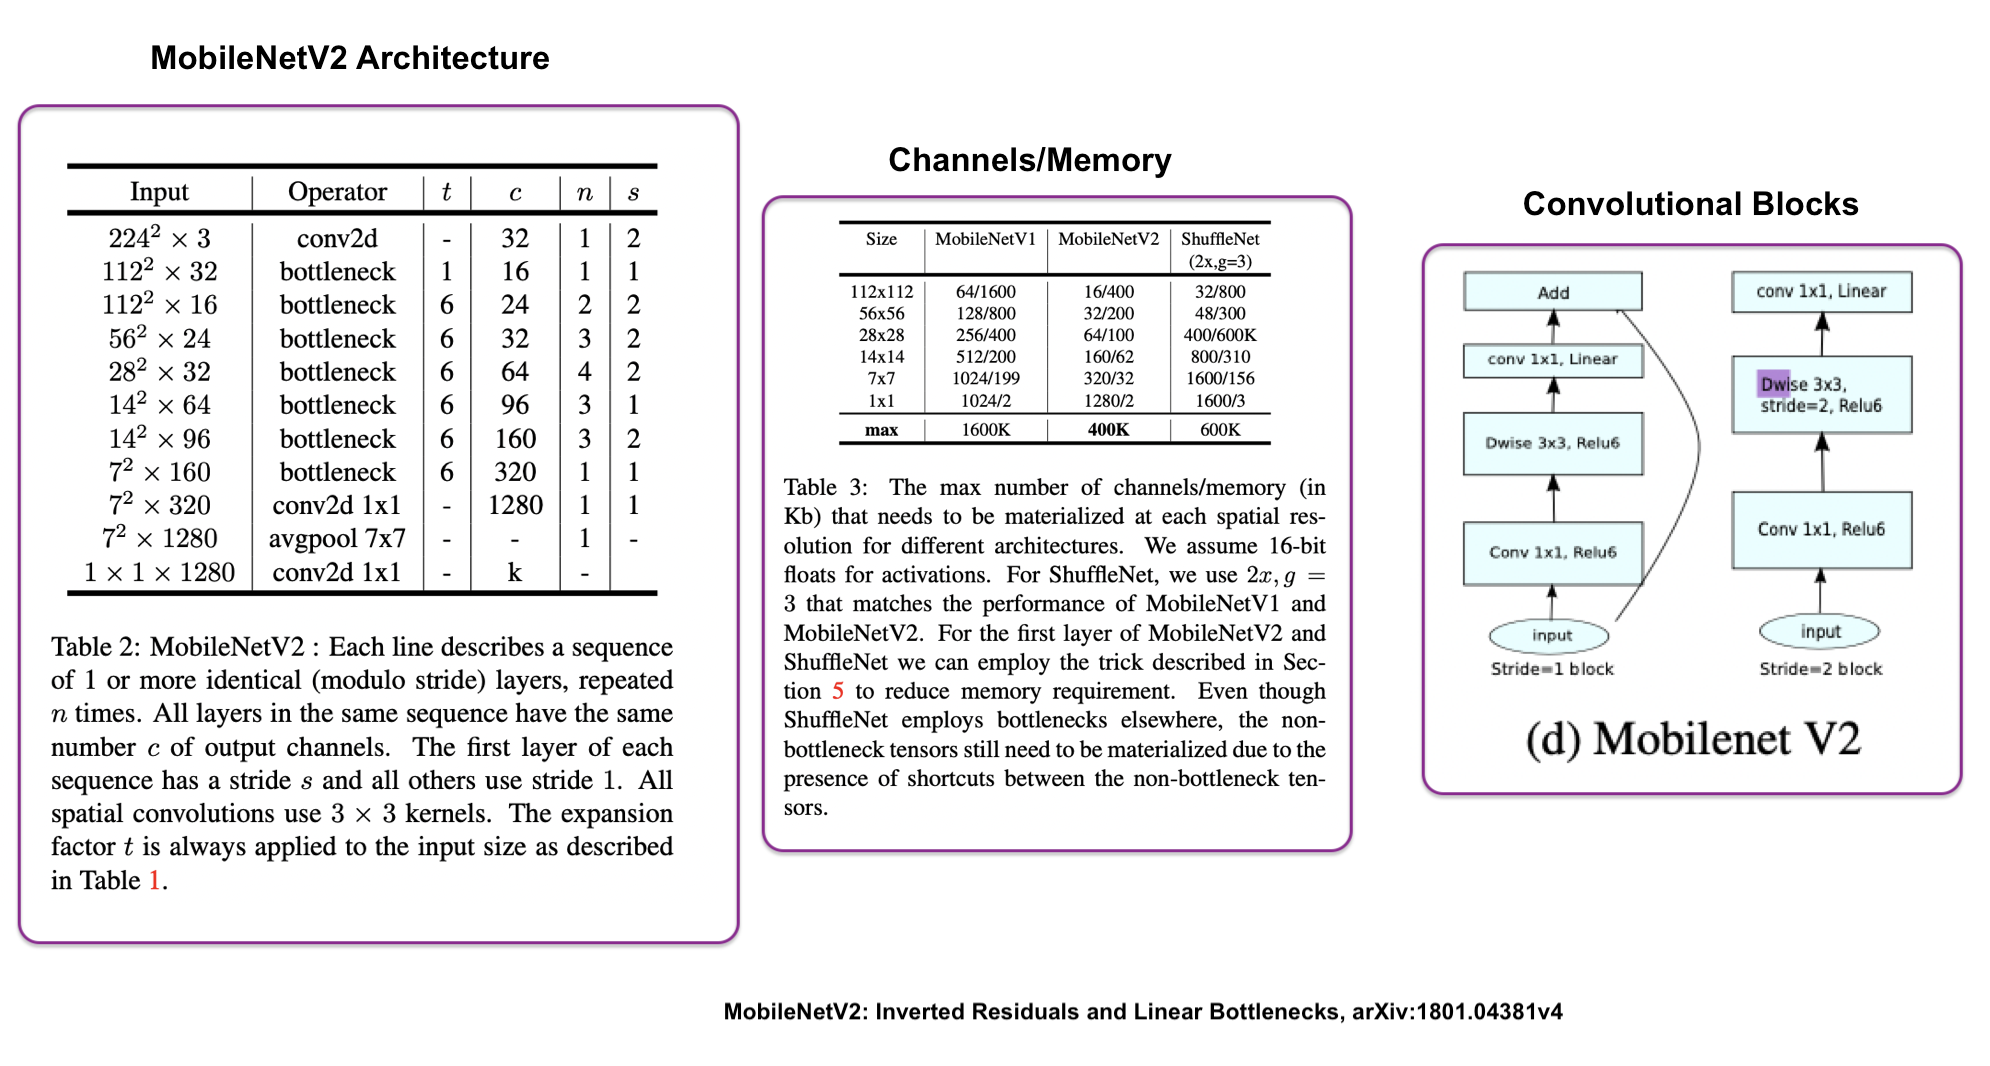

<a name='5'></a>

## 5. MobileNetV2 Implementation

### Set Up

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

### The Inverted Residual Block

In [ ]:
def inverted_res_block(input, in_channels, out_channels, t, strides):
  """
  Arugments:
  ---------
  input: input tensor
  in_channels: number of channels from the previous tensor(input)
  out_channels: number of output channels in the conv block
  t: the expansion rate, t = 1 for the first bottleneck, t = 6 for other bottlenecks
  strides: strides in 3x3 depthwise convolution, strides=1 as there is a shortcut.

  -------
  notes on strides: the first residual block in blocks has stride s and other has stride 1
  """

  x = layers.Conv2D(filters=in_channels * t, kernel_size=1, strides=1, padding='same')(input)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=out_channels, kernel_size=1, strides=1, padding='same', activation=None)(x)
  x = layers.BatchNormalization()(x)

  # if the strides in depthwise conv is 1, add identity shortcut
  if strides == 1 and in_channels == out_channels:
    
    shortcut = input
    x = layers.Add()([x, shortcut])

  return x

### Building the Whole MobileNet

In [ ]:
input = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = inverted_res_block(x, 32, 16 , t=1, strides=1)

x = inverted_res_block(x, 16, 24, t=6, strides=2)
x = inverted_res_block(x, 16, 24, t=6, strides=1)

x = inverted_res_block(x, 24, 32, t=6, strides=2)
x = inverted_res_block(x, 24, 32, t=6, strides=1)
x = inverted_res_block(x, 24, 32, t=6, strides=1)

x = inverted_res_block(x, 32, 64, t=6, strides=2)
x = inverted_res_block(x, 32, 64, t=6, strides=1)
x = inverted_res_block(x, 32, 64, t=6, strides=1)
x = inverted_res_block(x, 32, 64, t=6, strides=1)

x = inverted_res_block(x, 64, 96, t=6, strides=1)
x = inverted_res_block(x, 64, 96, t=6, strides=1)
x = inverted_res_block(x, 64, 96, t=6, strides=1)


x = inverted_res_block(x, 96, 160, t=6, strides=2)
x = inverted_res_block(x, 96, 160, t=6, strides=1)
x = inverted_res_block(x, 96, 160, t=6, strides=1)

x = inverted_res_block(x, 160, 320, t=6, strides=1)

x = layers.Conv2D(filters=1280, kernel_size=1, strides=1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(1000, activation='softmax')(x)

mobilenetv2 = keras.Model(input, output)

In [ ]:
mobilenetv2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      1056      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                             

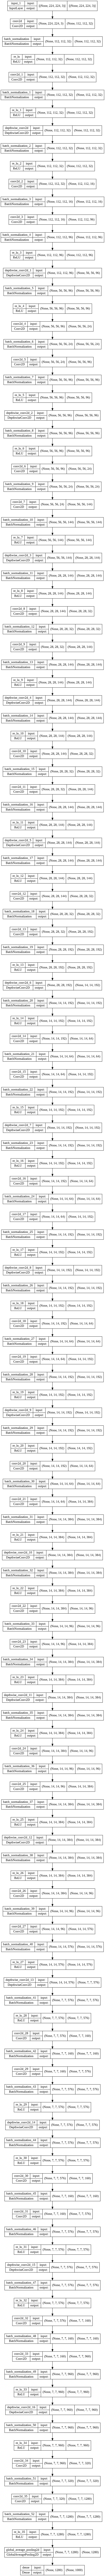

In [ ]:
keras.utils.plot_model(mobilenetv2, show_shapes=True)

<a name='6'></a>

## 6. Final Notes

MobileNetV2 is a computationally efficient network that is suited for mobile visual applications. MobileNetv2 uses inverted residual blocks whose intermediate layer is depthwise convolutions and bottlenecks(1x1 layers) in between. As reported in the paper, the inverted residual blocks improves memory efficieny which is the most important thing for mobile applications as mobile devices typically have low memory and power.

MobileNetV2 also achieved excellent results on computer vision downstream tasks such as object detection and image segmentation.

The next version of MobileNets models is [MobileNetV3](https://arxiv.org/abs/1905.02244) that is based on neural architecture search(NAS) complimented by [NetAdapt](https://arxiv.org/abs/1905.02244). MobileNetV3 also uses `h-switch` non-linearity(variant of ReLU) and [squeeze-and-excitation block](https://arxiv.org/abs/1709.01507v4) which improves the representation power. H-switch activation improves the accuracy compared to ReLU. Below is the formula of `h-switch` non-linearity.

$$h-switch(x) = x \frac{ReLU6(x+3)}{6}$$

<a name='7'></a>

## 7. References Implementation

* [Keras Applications, MobileNetV2](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py)

* [Wansoo Kim MobileNetV2 TF implementation](https://github.com/marload/ConvNets-TensorFlow2/blob/master/models/MobileNetV2.py)

### [BACK TO TOP](#0)